# SPARK Dataset


In [1]:
# import helper class
from utils import SPARKDataset , PyTorchSparkDataset
from matplotlib import pyplot as plt
from random import randint

import torch
import torchvision

# We are using BETA APIs, so we deactivate the associated warning, thereby acknowledging that
# some APIs may slightly change in the future
torchvision.disable_beta_transforms_warning()

Found Pytorch


In [2]:
# set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.
dataset_root_dir='./data/' # dataset directory
split='train' #split: train, valid, test
total_images=9 # total number of images in the split
class_map= {'proba_2':0, 'cheops':1, 'debris':2, 'double_star':3, 'earth_observation_sat_1':4, 'lisa_pathfinder':5,
                           'proba_3_csc' :6, 'proba_3_ocs':7, 'smart_1':8, 'soho':9, 'xmm_newton':10} # Class map

dataset = SPARKDataset(class_map, root_dir=dataset_root_dir,split=split)

### Displaying random set of images

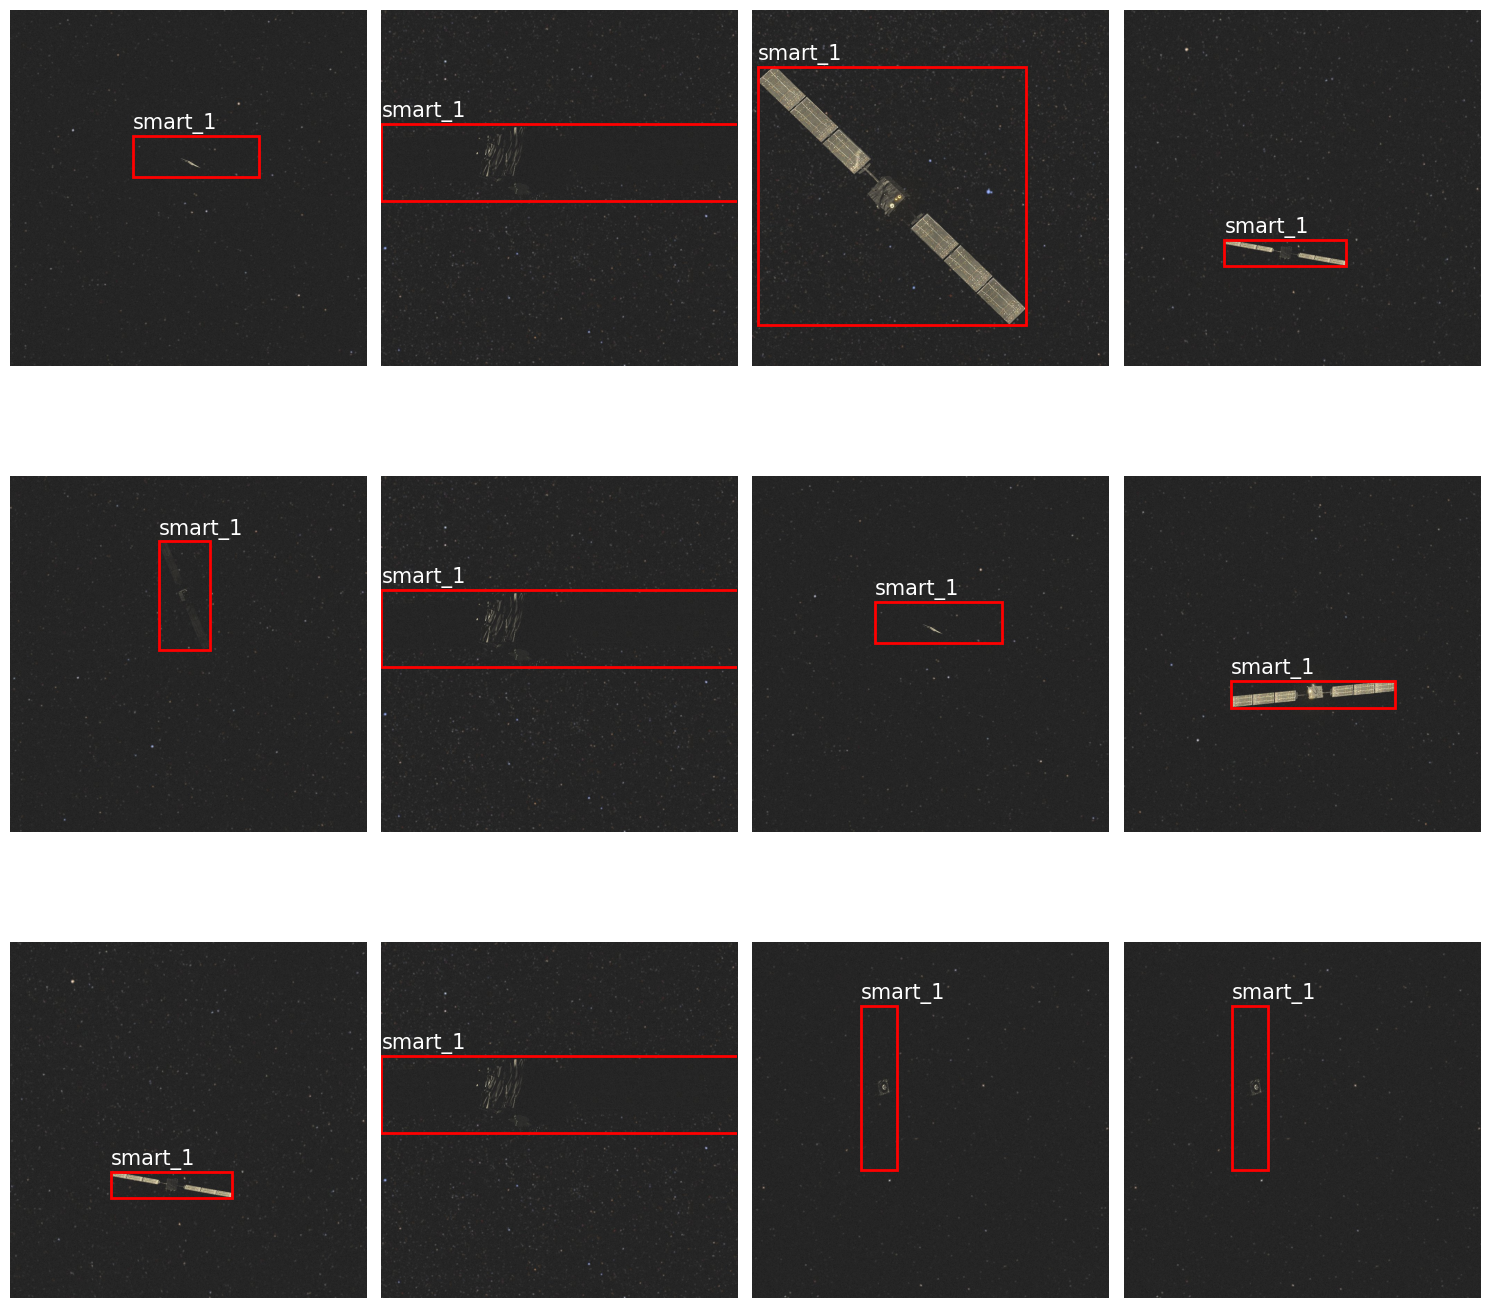

In [3]:
rows = 3
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i in range(rows):
    for j in range(cols):
        dataset.visualize(randint(0, total_images),size = (10,10),ax=axes[i][j])
        axes[i][j].axis('off')
fig.tight_layout() 

In [12]:
# Wrap a PyTorchSparkDataset dataset for usage with torchvision.transforms.v2

class PyTorchSparkDatasetV2(torch.utils.data.Dataset):

    def __init__(self, class_map, split='train', root_dir='', transform=None, detection=True):
        super().__init__()
        self.dataset = PyTorchSparkDataset(class_map, split=split, root_dir=root_dir, transform=transform, detection=True)

    def __getitem__(self, idx):
        image, label, bbox = self.dataset[idx]

        image = torchvision.tv_tensors.Image(image)
        label = torch.tensor([label])
        bbox = torchvision.tv_tensors.BoundingBoxes(bbox,
                                                    format = torchvision.tv_tensors.BoundingBoxFormat.XYXY, 
                                                    canvas_size=image.size)

        target = {'boxes': bbox, 'labels': label}
        return image, target

### Pytorch Dataset and Dataloader for SPARK

In [47]:
from torchvision.transforms import v2
from torchvision import models, datasets, tv_tensors

batch_size = 10

transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        # v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [48]:
dataset = PyTorchSparkDatasetV2(class_map, root_dir=dataset_root_dir, split='train', transform=transforms)

In [49]:
sample = dataset[0]
image, target = sample
print(type(image))
print(type(target), list(target.keys()))
print(type(target["boxes"]), type(target["labels"]))

<class 'torchvision.tv_tensors._image.Image'>
<class 'dict'> ['boxes', 'labels']
<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torch.Tensor'>


In [51]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

model = models.get_model("fasterrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None).train()

for imgs, targets in data_loader:
    loss_dict = model(imgs, targets)
    # Put your training logic here

    print(f"{[img.shape for img in imgs] = }")
    print(f"{[type(target) for target in targets] = }")
    for name, loss_val in loss_dict.items():
        print(f"{name:<20}{loss_val:.3f}")

[img.shape for img in imgs] = [torch.Size([3, 3018, 3018]), torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([3, 3121, 3121]), torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([3, 3178, 3178]), torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024])]
[type(target) for target in targets] = [<class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>]
loss_classifier     4.374
loss_box_reg        0.002
loss_objectness     0.691
loss_rpn_box_reg    0.045
[img.shape for img in imgs] = [torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 1024]), torch.Size([3, 3610, 3610]), torch.Size([3, 2782, 2782]), torch.Size([3, 1024, 1024]), torch.Size([3, 1759, 1759]), torch.Size([3, 2989, 2989]), torch.Size([3, 3674, 3674]), torch.Size([3, 3744, 3744])]
[type(target) for target in targets] = [<class 'dict'>

KeyboardInterrupt: 